# Basketball Analysis: NBA -- Part 1
## Frank Li, Randy Zhu, Jeremy Knox, Daniel White
### Introduction/Background

Basketball is one the three most popular sports in USA. While watching basketball games is very exciting, they also involve a lot of techniques to do well in this sport. So we believe that it's reseanable and valuable to analyze any data or features recored for every match. On the website http://stats.nba.com/stats/, it provides a lot of features, such as, field goals made, field goals attempted, player fouls,etc, both on team basis and player basis. In this project, we first pull match data for a particular team, Warriors, and try to predict its future performances based on the past. Next, we also utilize several player data from both Warriors and Rockets, and try to compare them. Overall, our goal is to use data science methods to understand this sport better and assess teams or players more accurately.

### PCA & Regression Analysis

### Data Set:  
#### Team data: 10 matches between Warriors and Rockets
http://stats.nba.com/stats/   
Regular season (n = 4)  
https://stats.nba.com/game/0021800213/	Rockets  
https://stats.nba.com/game/0021800565/	Rockets  
https://stats.nba.com/game/0021800892/	Rockets  
https://stats.nba.com/game/0021801018/	Warriors  
Playoffs (n = 6) | Harden & Curry shot patterns  
https://stats.nba.com/game/0041800226/	Warriors  
https://stats.nba.com/game/0041800225/	Warriors  
https://stats.nba.com/game/0041800224/	Rockets  
https://stats.nba.com/game/0041800223/	Rockets  
https://stats.nba.com/game/0041800222/	Warriors  
https://stats.nba.com/game/0041800221/	Warriors
#### Player data: season perfomance stats for 10 players from Warriors and Rockets

### Questions of Interest
1. There are way too many features in the match dataframe. Can we use PCA to extract the most important characteristics? Can we separate the games that Warriors won from those they lost?
2. Is there a regression relationship between match stats and final points? Can we build a model based on previous match data to predict next match's points? Is there a difference between a normal model and a model on PCA applied matrix?

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import players

First, we pull data from the 10 matches listed above

In [21]:
nba_teams = teams.get_teams() #get a list of all teams in NBA
# Select the dictionary for Warriors, which contains their team ID
warriors = [team for team in nba_teams if team['abbreviation'] == 'GSW'][0]
warriors_id = warriors['id']

# Query for games where the Warriors were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable = warriors_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42018,1610612744,GSW,Golden State Warriors,0041800406,2019-06-13,GSW vs. TOR,None,119,70,...,0.875,7.0,20.0,27.0,15,4.0,5,10.0,13,-3.0
1,42018,1610612744,GSW,Golden State Warriors,0041800405,2019-06-10,GSW @ TOR,W,240,106,...,0.714,6.0,31.0,37.0,27,5.0,7,15.0,22,1.0
2,42018,1610612744,GSW,Golden State Warriors,0041800404,2019-06-07,GSW vs. TOR,L,241,92,...,0.667,8.0,34.0,42.0,26,6.0,6,17.0,23,-13.0
3,42018,1610612744,GSW,Golden State Warriors,0041800403,2019-06-05,GSW vs. TOR,L,241,109,...,0.833,13.0,28.0,41.0,25,8.0,3,14.0,21,-14.0
4,42018,1610612744,GSW,Golden State Warriors,0041800402,2019-06-02,GSW @ TOR,W,240,109,...,0.870,6.0,36.0,42.0,34,7.0,5,15.0,26,5.0


Filter out all 2018-19 season games

In [22]:
games = games[games.SEASON_ID.str[-4:] == '2018']
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42018,1610612744,GSW,Golden State Warriors,0041800406,2019-06-13,GSW vs. TOR,None,119,70,...,0.875,7.0,20.0,27.0,15,4.0,5,10.0,13,-3.0
1,42018,1610612744,GSW,Golden State Warriors,0041800405,2019-06-10,GSW @ TOR,W,240,106,...,0.714,6.0,31.0,37.0,27,5.0,7,15.0,22,1.0
2,42018,1610612744,GSW,Golden State Warriors,0041800404,2019-06-07,GSW vs. TOR,L,241,92,...,0.667,8.0,34.0,42.0,26,6.0,6,17.0,23,-13.0
3,42018,1610612744,GSW,Golden State Warriors,0041800403,2019-06-05,GSW vs. TOR,L,241,109,...,0.833,13.0,28.0,41.0,25,8.0,3,14.0,21,-14.0
4,42018,1610612744,GSW,Golden State Warriors,0041800402,2019-06-02,GSW @ TOR,W,240,109,...,0.870,6.0,36.0,42.0,34,7.0,5,15.0,26,5.0


Filter out games against Rockets

In [23]:
vrockets = games[games.MATCHUP.str.contains('HOU')]
vrockets

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
10,42018,1610612744,GSW,Golden State Warriors,0041800226,2019-05-10,GSW @ HOU,W,241,118,...,0.783,10.0,25.0,35.0,25,9.0,7,17.0,19,5.0
11,42018,1610612744,GSW,Golden State Warriors,0041800225,2019-05-08,GSW vs. HOU,W,240,104,...,0.722,12.0,30.0,42.0,28,6.0,1,15.0,19,5.0
12,42018,1610612744,GSW,Golden State Warriors,0041800224,2019-05-06,GSW @ HOU,L,239,108,...,0.696,8.0,35.0,43.0,24,6.0,2,11.0,21,-4.0
13,42018,1610612744,GSW,Golden State Warriors,0041800223,2019-05-04,GSW @ HOU,L,266,121,...,0.793,7.0,28.0,35.0,27,6.0,6,8.0,22,-5.0
14,42018,1610612744,GSW,Golden State Warriors,0041800222,2019-04-30,GSW vs. HOU,W,239,115,...,0.833,18.0,27.0,45.0,24,10.0,5,12.0,23,6.0
15,42018,1610612744,GSW,Golden State Warriors,0041800221,2019-04-28,GSW vs. HOU,W,239,104,...,0.778,8.0,30.0,38.0,24,7.0,3,20.0,24,4.0
37,22018,1610612744,GSW,Golden State Warriors,0021801018,2019-03-13,GSW @ HOU,W,240,106,...,1.000,12.0,32.0,44.0,28,7.0,2,14.0,20,2.0
45,22018,1610612744,GSW,Golden State Warriors,0021800892,2019-02-23,GSW vs. HOU,L,240,112,...,0.700,9.0,36.0,45.0,26,9.0,10,17.0,19,-6.0
65,22018,1610612744,GSW,Golden State Warriors,0021800565,2019-01-03,GSW vs. HOU,L,264,134,...,0.933,9.0,38.0,47.0,33,8.0,6,14.0,19,-1.0
88,22018,1610612744,GSW,Golden State Warriors,0021800213,2018-11-15,GSW @ HOU,L,238,86,...,0.818,12.0,32.0,44.0,18,2.0,5,16.0,24,-21.0


Drop row i=107 since it belongs to last season.

In [24]:
vrockets = vrockets.drop(vrockets.index[-1])
vrockets

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
10,42018,1610612744,GSW,Golden State Warriors,0041800226,2019-05-10,GSW @ HOU,W,241,118,...,0.783,10.0,25.0,35.0,25,9.0,7,17.0,19,5.0
11,42018,1610612744,GSW,Golden State Warriors,0041800225,2019-05-08,GSW vs. HOU,W,240,104,...,0.722,12.0,30.0,42.0,28,6.0,1,15.0,19,5.0
12,42018,1610612744,GSW,Golden State Warriors,0041800224,2019-05-06,GSW @ HOU,L,239,108,...,0.696,8.0,35.0,43.0,24,6.0,2,11.0,21,-4.0
13,42018,1610612744,GSW,Golden State Warriors,0041800223,2019-05-04,GSW @ HOU,L,266,121,...,0.793,7.0,28.0,35.0,27,6.0,6,8.0,22,-5.0
14,42018,1610612744,GSW,Golden State Warriors,0041800222,2019-04-30,GSW vs. HOU,W,239,115,...,0.833,18.0,27.0,45.0,24,10.0,5,12.0,23,6.0
15,42018,1610612744,GSW,Golden State Warriors,0041800221,2019-04-28,GSW vs. HOU,W,239,104,...,0.778,8.0,30.0,38.0,24,7.0,3,20.0,24,4.0
37,22018,1610612744,GSW,Golden State Warriors,0021801018,2019-03-13,GSW @ HOU,W,240,106,...,1.000,12.0,32.0,44.0,28,7.0,2,14.0,20,2.0
45,22018,1610612744,GSW,Golden State Warriors,0021800892,2019-02-23,GSW vs. HOU,L,240,112,...,0.700,9.0,36.0,45.0,26,9.0,10,17.0,19,-6.0
65,22018,1610612744,GSW,Golden State Warriors,0021800565,2019-01-03,GSW vs. HOU,L,264,134,...,0.933,9.0,38.0,47.0,33,8.0,6,14.0,19,-1.0
88,22018,1610612744,GSW,Golden State Warriors,0021800213,2018-11-15,GSW @ HOU,L,238,86,...,0.818,12.0,32.0,44.0,18,2.0,5,16.0,24,-21.0


In [25]:
vrockets = vrockets.reset_index(drop=True)
vrockets

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42018,1610612744,GSW,Golden State Warriors,0041800226,2019-05-10,GSW @ HOU,W,241,118,...,0.783,10.0,25.0,35.0,25,9.0,7,17.0,19,5.0
1,42018,1610612744,GSW,Golden State Warriors,0041800225,2019-05-08,GSW vs. HOU,W,240,104,...,0.722,12.0,30.0,42.0,28,6.0,1,15.0,19,5.0
2,42018,1610612744,GSW,Golden State Warriors,0041800224,2019-05-06,GSW @ HOU,L,239,108,...,0.696,8.0,35.0,43.0,24,6.0,2,11.0,21,-4.0
3,42018,1610612744,GSW,Golden State Warriors,0041800223,2019-05-04,GSW @ HOU,L,266,121,...,0.793,7.0,28.0,35.0,27,6.0,6,8.0,22,-5.0
4,42018,1610612744,GSW,Golden State Warriors,0041800222,2019-04-30,GSW vs. HOU,W,239,115,...,0.833,18.0,27.0,45.0,24,10.0,5,12.0,23,6.0
5,42018,1610612744,GSW,Golden State Warriors,0041800221,2019-04-28,GSW vs. HOU,W,239,104,...,0.778,8.0,30.0,38.0,24,7.0,3,20.0,24,4.0
6,22018,1610612744,GSW,Golden State Warriors,0021801018,2019-03-13,GSW @ HOU,W,240,106,...,1.000,12.0,32.0,44.0,28,7.0,2,14.0,20,2.0
7,22018,1610612744,GSW,Golden State Warriors,0021800892,2019-02-23,GSW vs. HOU,L,240,112,...,0.700,9.0,36.0,45.0,26,9.0,10,17.0,19,-6.0
8,22018,1610612744,GSW,Golden State Warriors,0021800565,2019-01-03,GSW vs. HOU,L,264,134,...,0.933,9.0,38.0,47.0,33,8.0,6,14.0,19,-1.0
9,22018,1610612744,GSW,Golden State Warriors,0021800213,2018-11-15,GSW @ HOU,L,238,86,...,0.818,12.0,32.0,44.0,18,2.0,5,16.0,24,-21.0


In [26]:
for i in range(10):
    if vrockets.WL[i]=='W':
        vrockets.WL[i]=1
    else:
        vrockets.WL[i]=0

C:\Users\smile\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\smile\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Change values of WL. If Warriors wins the game, change it to 1, else 0.

In [27]:
vrockets

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42018,1610612744,GSW,Golden State Warriors,0041800226,2019-05-10,GSW @ HOU,1,241,118,...,0.783,10.0,25.0,35.0,25,9.0,7,17.0,19,5.0
1,42018,1610612744,GSW,Golden State Warriors,0041800225,2019-05-08,GSW vs. HOU,1,240,104,...,0.722,12.0,30.0,42.0,28,6.0,1,15.0,19,5.0
2,42018,1610612744,GSW,Golden State Warriors,0041800224,2019-05-06,GSW @ HOU,0,239,108,...,0.696,8.0,35.0,43.0,24,6.0,2,11.0,21,-4.0
3,42018,1610612744,GSW,Golden State Warriors,0041800223,2019-05-04,GSW @ HOU,0,266,121,...,0.793,7.0,28.0,35.0,27,6.0,6,8.0,22,-5.0
4,42018,1610612744,GSW,Golden State Warriors,0041800222,2019-04-30,GSW vs. HOU,1,239,115,...,0.833,18.0,27.0,45.0,24,10.0,5,12.0,23,6.0
5,42018,1610612744,GSW,Golden State Warriors,0041800221,2019-04-28,GSW vs. HOU,1,239,104,...,0.778,8.0,30.0,38.0,24,7.0,3,20.0,24,4.0
6,22018,1610612744,GSW,Golden State Warriors,0021801018,2019-03-13,GSW @ HOU,1,240,106,...,1.000,12.0,32.0,44.0,28,7.0,2,14.0,20,2.0
7,22018,1610612744,GSW,Golden State Warriors,0021800892,2019-02-23,GSW vs. HOU,0,240,112,...,0.700,9.0,36.0,45.0,26,9.0,10,17.0,19,-6.0
8,22018,1610612744,GSW,Golden State Warriors,0021800565,2019-01-03,GSW vs. HOU,0,264,134,...,0.933,9.0,38.0,47.0,33,8.0,6,14.0,19,-1.0
9,22018,1610612744,GSW,Golden State Warriors,0021800213,2018-11-15,GSW @ HOU,0,238,86,...,0.818,12.0,32.0,44.0,18,2.0,5,16.0,24,-21.0


In [28]:
vrockets.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS'],
      dtype='object')

Drop useless columns such as season id, team id, etc.

In [29]:
dropped = vrockets.drop(columns=['WL','SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP'])
dropped

,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,241,118,42,85,0.494,16,38.0,0.421,18,23,0.783,10.0,25.0,35.0,25,9.0,7,17.0,19,5.0
1,240,104,39,85,0.459,13,37.0,0.351,13,18,0.722,12.0,30.0,42.0,28,6.0,1,15.0,19,5.0
2,239,108,42,90,0.467,8,33.0,0.242,16,23,0.696,8.0,35.0,43.0,24,6.0,2,11.0,21,-4.0
3,266,121,42,95,0.442,14,33.0,0.424,23,29,0.793,7.0,28.0,35.0,27,6.0,6,8.0,22,-5.0
4,239,115,42,91,0.462,11,36.0,0.306,20,24,0.833,18.0,27.0,45.0,24,10.0,5,12.0,23,6.0
5,239,104,38,75,0.507,7,22.0,0.318,21,27,0.778,8.0,30.0,38.0,24,7.0,3,20.0,24,4.0
6,240,106,42,85,0.494,12,32.0,0.375,10,10,1.000,12.0,32.0,44.0,28,7.0,2,14.0,20,2.0
7,240,112,42,90,0.467,14,36.0,0.389,14,20,0.700,9.0,36.0,45.0,26,9.0,10,17.0,19,-6.0
8,264,134,53,102,0.520,14,37.0,0.378,14,15,0.933,9.0,38.0,47.0,33,8.0,6,14.0,19,-1.0
9,238,86,32,76,0.421,4,18.0,0.222,18,22,0.818,12.0,32.0,44.0,18,2.0,5,16.0,24,-21.0


## PCA
### The match stats dataframe has way too many features. Are there certain features correlated? Can we convert it into a set of values of linearly uncorrelated variables?

PCA is essentially a method that reduces the dimension of the feature space in such a way that new variables are orthogonal to each other (i.e. they are independent or not correlated).

Drop out useless columns for PCA analysis:

In [30]:
dropped = dropped.drop(columns=['PLUS_MINUS'])
dropped

,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF
0,241,118,42,85,0.494,16,38.0,0.421,18,23,0.783,10.0,25.0,35.0,25,9.0,7,17.0,19
1,240,104,39,85,0.459,13,37.0,0.351,13,18,0.722,12.0,30.0,42.0,28,6.0,1,15.0,19
2,239,108,42,90,0.467,8,33.0,0.242,16,23,0.696,8.0,35.0,43.0,24,6.0,2,11.0,21
3,266,121,42,95,0.442,14,33.0,0.424,23,29,0.793,7.0,28.0,35.0,27,6.0,6,8.0,22
4,239,115,42,91,0.462,11,36.0,0.306,20,24,0.833,18.0,27.0,45.0,24,10.0,5,12.0,23
5,239,104,38,75,0.507,7,22.0,0.318,21,27,0.778,8.0,30.0,38.0,24,7.0,3,20.0,24
6,240,106,42,85,0.494,12,32.0,0.375,10,10,1.000,12.0,32.0,44.0,28,7.0,2,14.0,20
7,240,112,42,90,0.467,14,36.0,0.389,14,20,0.700,9.0,36.0,45.0,26,9.0,10,17.0,19
8,264,134,53,102,0.520,14,37.0,0.378,14,15,0.933,9.0,38.0,47.0,33,8.0,6,14.0,19
9,238,86,32,76,0.421,4,18.0,0.222,18,22,0.818,12.0,32.0,44.0,18,2.0,5,16.0,24


Standardize the data:

In [31]:
scaler = StandardScaler()
scaler.fit(dropped)
scaledropped = scaler.transform(dropped)
scaledropped

C:\Users\smile\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\smile\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[-0.35159201,  0.59759784,  0.12186667, -0.31025261,  0.71850316,
         1.30304439,  0.89968447,  1.18315667,  0.34010909,  0.35596506,
        -0.2429821 , -0.16439899, -1.60486768, -1.67100884, -0.19115411,
         0.93250481,  0.88136192,  0.79708114, -1.        ],
       [-0.44925645, -0.56439796, -0.48746668, -0.31025261, -0.49635726,
         0.47131393,  0.74456646,  0.12676679, -0.96800281, -0.5807851 ,
        -0.89881874,  0.49319696, -0.33116317,  0.04914732,  0.62807781,
        -0.4662524 , -1.41784308,  0.1839418 , -1.        ],
       [-0.5469209 , -0.23239916,  0.12186667,  0.336107  , -0.21867488,
        -0.91490351,  0.12409441, -1.51818318, -0.18313567,  0.35596506,
        -1.17835567, -0.82199494,  0.94254133,  0.29488391, -0.46423142,
        -0.4662524 , -1.03464225, -1.04233688,  0.        ],
       [ 2.09001916,  0.84659694,  0.12186667,  0.98246661, -1.08643232,
         0.74855741,  0.12409441,  1.22843052,  1.64822099,  1.48006527,
        -0.135

Iterate through all components to see what number of components has the highest variance, i.e. explains the most variablity.

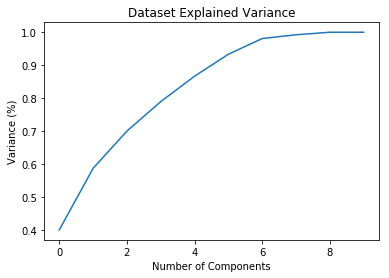

In [32]:
pca = PCA().fit(scaledropped)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

This plot implies that selecting 6 components can preserve something around 98.8% or 99% of the total variance of the data. It makes sense, we’ll not use 100% of our variance, because it denotes all components, and we want only the principal ones.  
Mathematically, the transformation is defined by a set of p-dimensional vectors of weights or coefficients ${\displaystyle \mathbf {w} _{(k)}=(w_{1},\dots ,w_{p})_{(k)}} \mathbf {w} _{(k)}=(w_{1},\dots ,w_{p})_{(k)}$ that map each row vector ${\displaystyle \mathbf {x} _{(i)}} \mathbf{x}_{(i)}$ of X to a new vector of principal component scores ${\displaystyle \mathbf {t} _{(i)}=(t_{1},\dots ,t_{l})_{(i)}} {\displaystyle \mathbf {t} _{(i)}=(t_{1},\dots ,t_{l})_{(i)}}$.  

In order to maximize variance, the first weight vector w(1) thus has to satisfy
${\displaystyle \mathbf {w} _{(1)}={\underset {\Vert \mathbf {w} \Vert =1}{\operatorname {\arg \,max} }}\,\left\{\sum _{i}\left(t_{1}\right)_{(i)}^{2}\right\}={\underset {\Vert \mathbf {w} \Vert =1}{\operatorname {\arg \,max} }}\,\left\{\sum _{i}\left(\mathbf {x} _{(i)}\cdot \mathbf {w} \right)^{2}\right\}} {\mathbf  {w}}_{{(1)}}={\underset  {\Vert {\mathbf  {w}}\Vert =1}{\operatorname {\arg \,max}}}\,\left\{\sum _{i}\left(t_{1}\right)_{{(i)}}^{2}\right\}={\underset  {\Vert {\mathbf  {w}}\Vert =1}{\operatorname {\arg \,max}}}\,\left\{\sum _{i}\left({\mathbf  {x}}_{{(i)}}\cdot {\mathbf  {w}}\right)^{2}\right\}$.

The kth component can be found by subtracting the first k − 1 principal components from X:
${\displaystyle \mathbf {\hat {X}} _{k}=\mathbf {X} -\sum _{s=1}^{k-1}\mathbf {X} \mathbf {w} _{(s)}\mathbf {w} _{(s)}^{\rm {T}}} {\mathbf  {{\hat  {X}}}}_{{k}}={\mathbf  {X}}-\sum _{{s=1}}^{{k-1}}{\mathbf  {X}}{\mathbf  {w}}_{{(s)}}{\mathbf  {w}}_{{(s)}}^{{{\rm {T}}}}$.  
The full principal components decomposition of X can therefore be given as
${\displaystyle \mathbf {T} =\mathbf {X} \mathbf {W} }$
where $W$ is a p-by-p matrix of weights whose columns are the eigenvectors of $X^TX$.

In [33]:
pca = PCA(n_components=6)
dataset = pca.fit_transform(scaledropped) #Fit the model with scaled data and apply the dimensionality reduction on it

Obtain the matrix of phi values:

In [34]:
phi = pca.components_
phi

array([[-0.21360589, -0.32875161, -0.33660326, -0.30410356, -0.21212903,
        -0.31442177, -0.30411177, -0.27064038,  0.12759237,  0.14594074,
        -0.10902118,  0.05848864, -0.09069459, -0.04377565, -0.33292522,
        -0.23974265, -0.11037856,  0.09204947,  0.28093605],
       [ 0.20509731,  0.15909708, -0.03194504,  0.0585188 , -0.11526785,
         0.13900178,  0.04730413,  0.19732625,  0.45261345,  0.45511465,
        -0.21276861, -0.15680899, -0.32094961, -0.42680072, -0.07022246,
         0.08330968,  0.19238073, -0.14925137,  0.12736341],
       [-0.41438897, -0.08671693, -0.13937436, -0.30241109,  0.20409768,
         0.21050423,  0.15214298,  0.21690666, -0.11293361, -0.06055914,
        -0.10604191,  0.17818465, -0.33392243, -0.1889479 , -0.05741435,
         0.33057208,  0.05724289,  0.44233156, -0.18865462],
       [-0.11351771,  0.00934612, -0.02863993,  0.17536176, -0.31410676,
         0.07289465,  0.25877278, -0.10425484,  0.03445312, -0.02256444,
         0.094

After applying PCA to normalized data, we successfully compressd the dimension to 6.

In [35]:
dataset

array([[-1.35781403,  2.01127736,  2.68422583, -0.2829483 , -0.11606288,
         0.30568718],
       [-0.02207406, -1.01532863,  0.96320606,  0.51332103,  0.7154122 ,
         1.95794099],
       [ 1.05236106, -0.54840002, -1.46008353, -0.11941659,  1.24839439,
         0.33870122],
       [-1.01803056,  4.09496222, -2.01063168,  0.09686963, -0.33310479,
         1.14533751],
       [ 0.28548025,  0.53220884,  0.38746848,  3.25576709, -0.52984528,
        -1.62344044],
       [ 2.89657035,  0.82884515,  0.96693411, -2.14244975, -1.54057129,
        -1.05856589],
       [-1.06872642, -2.97676236,  0.55963435,  0.30369735, -1.61068605,
         1.16347388],
       [-1.48861753, -0.36337123,  0.95084463, -0.73099666,  2.58233649,
        -1.04060707],
       [-5.12350428, -1.47349027, -1.82660119, -0.87419613, -0.67216381,
        -1.04287031],
       [ 5.84435523, -1.08994106, -1.21499705, -0.01964766,  0.25629101,
        -0.14565708]])

Sanity check

In [36]:
scaledropped - np.dot(dataset,phi)

array([[-0.01114547,  0.11141994,  0.14268841,  0.05899678,  0.05747071,
         0.00845226,  0.04467821, -0.25970717, -0.02435731, -0.14046175,
         0.2867316 , -0.02416458, -0.17737531, -0.18916573, -0.42750595,
        -0.2847049 ,  0.34529797,  0.00375374, -0.29378662],
       [ 0.21296986,  0.08342257,  0.04686642,  0.00580044,  0.0713892 ,
        -0.04144953,  0.11459066, -0.13322861,  0.18133444,  0.2553004 ,
        -0.56706515,  0.27769677, -0.00232394,  0.20530285,  0.51085188,
        -0.06291665, -0.61267101,  0.38057451,  0.04986741],
       [-0.64333635,  0.24574187,  0.41798187,  0.13608984,  0.72856752,
        -0.36001554,  0.41130045, -0.77334537,  0.03754665,  0.32582999,
        -0.55195478, -0.40671374,  0.04708108, -0.25855227, -0.1229167 ,
         0.4712547 , -1.01197485, -0.49436213, -0.02609401],
       [ 0.08782985, -0.13812617, -0.18068165, -0.06038007, -0.23380141,
         0.10292953, -0.16455266,  0.34985331, -0.06705282, -0.12043525,
         0.234

Convert the result into a dataframe:

In [37]:
pcadf = pd.DataFrame(data=dataset,
                     columns=['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5','principal component 6'])
pcadf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,-1.357814,2.011277,2.684226,-0.282948,-0.116063,0.305687
1,-0.022074,-1.015329,0.963206,0.513321,0.715412,1.957941
2,1.052361,-0.548400,-1.460084,-0.119417,1.248394,0.338701
3,-1.018031,4.094962,-2.010632,0.096870,-0.333105,1.145338
4,0.285480,0.532209,0.387468,3.255767,-0.529845,-1.623440
5,2.896570,0.828845,0.966934,-2.142450,-1.540571,-1.058566
6,-1.068726,-2.976762,0.559634,0.303697,-1.610686,1.163474
7,-1.488618,-0.363371,0.950845,-0.730997,2.582336,-1.040607
8,-5.123504,-1.473490,-1.826601,-0.874196,-0.672164,-1.042870
9,5.844355,-1.089941,-1.214997,-0.019648,0.256291,-0.145657


In [38]:
def shift(l, n):
    return l[n:] + l[:n]

In [39]:
shifted = list(vrockets['WL'])
shifted = shift(shifted,1)
shifted = pd.DataFrame(shifted,columns=['WL'])
shifted

,WL
0,1
1,0
2,0
3,1
4,1
5,1
6,0
7,0
8,0
9,1


In [40]:
finalpcadf = pd.concat([pcadf, shifted], axis = 1)
finalpcadf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,WL
0,-1.357814,2.011277,2.684226,-0.282948,-0.116063,0.305687,1
1,-0.022074,-1.015329,0.963206,0.513321,0.715412,1.957941,0
2,1.052361,-0.548400,-1.460084,-0.119417,1.248394,0.338701,0
3,-1.018031,4.094962,-2.010632,0.096870,-0.333105,1.145338,1
4,0.285480,0.532209,0.387468,3.255767,-0.529845,-1.623440,1
5,2.896570,0.828845,0.966934,-2.142450,-1.540571,-1.058566,1
6,-1.068726,-2.976762,0.559634,0.303697,-1.610686,1.163474,0
7,-1.488618,-0.363371,0.950845,-0.730997,2.582336,-1.040607,0
8,-5.123504,-1.473490,-1.826601,-0.874196,-0.672164,-1.042870,0
9,5.844355,-1.089941,-1.214997,-0.019648,0.256291,-0.145657,1


C:\Users\smile\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\smile\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


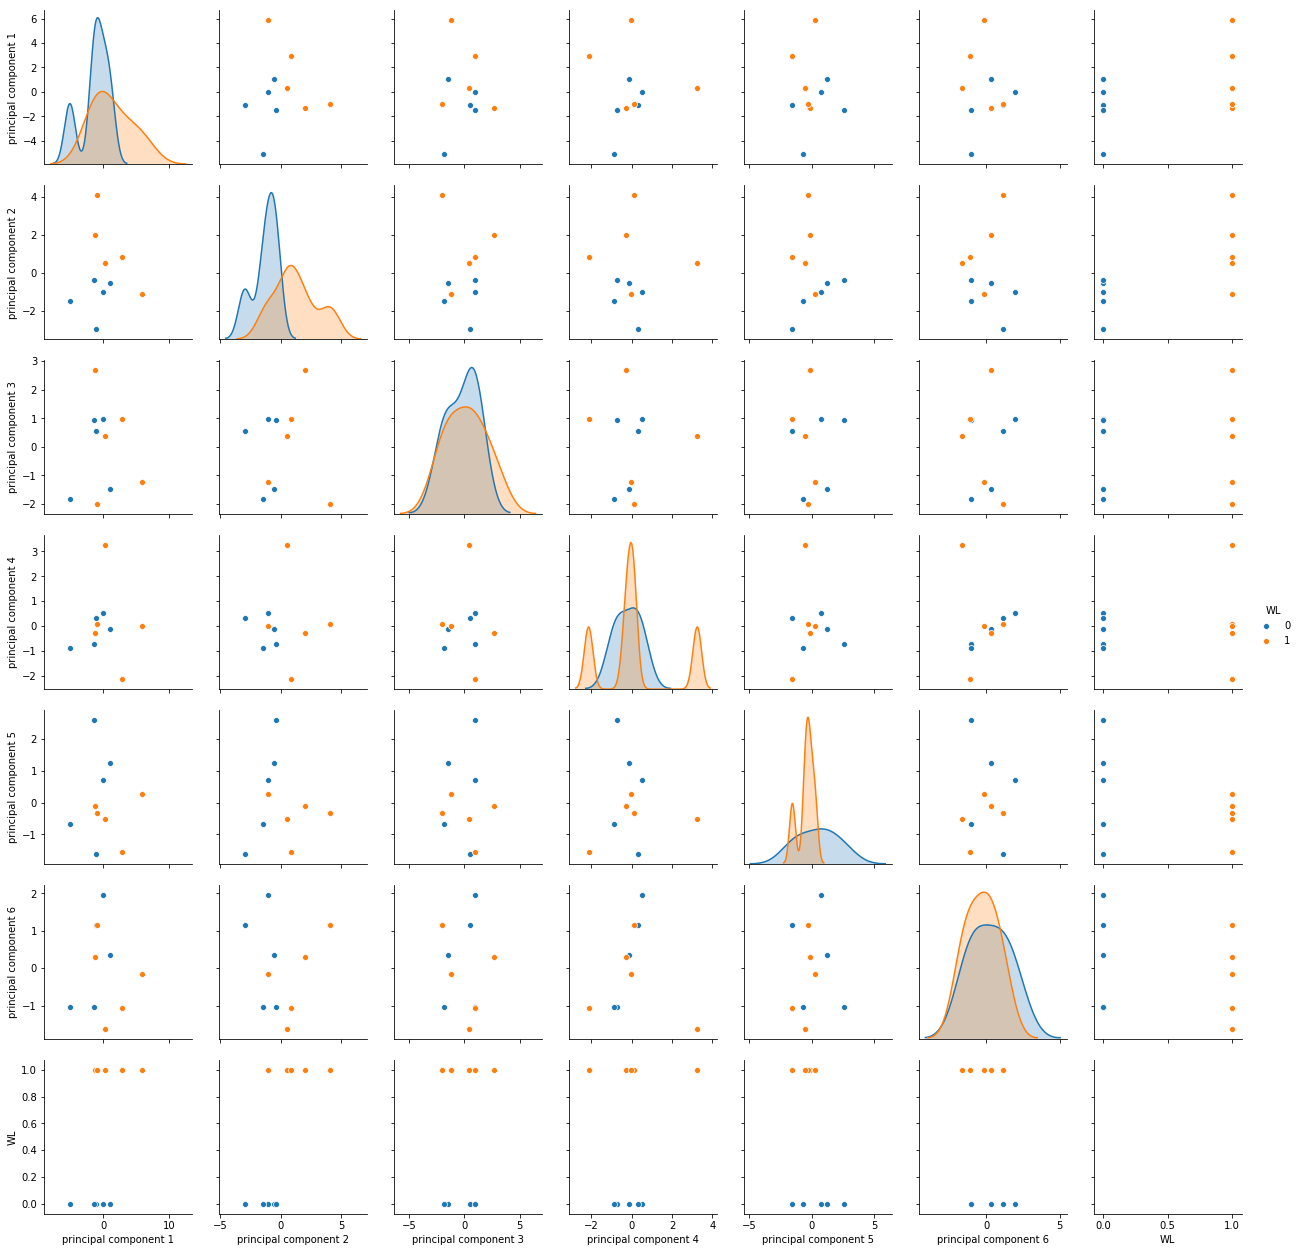

In [41]:
sns.pairplot(finalpcadf,hue='WL');

We can see that component 1 and 2 separate the data the best. This agrees with our assumption that component 1 explains the most variance. As a result, our use of PCA on reducing dimension and extract features is successful. For future study, we can use some other machine learning methods such as support vector machine, or even a neural network.

## Regression Analysis  
## Is there a linear regression model that can predict match points based on previous game stats? Is there a difference between a normal model and a model on PCA applied matrix?

First, we create a dataframe called games that contains all the Warriors matches in 2018-19 season. In order to do regression analysis, we drop useless columns such as season ID, team ID, etc.

In [42]:
df = games.drop(columns=['WL','SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP'])
df.head()

,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,119,70,25,52,0.481,6,17.0,0.353,14,16,0.875,7.0,20.0,27.0,15,4.0,5,10.0,13,-3.0
1,240,106,38,82,0.463,20,42.0,0.476,10,14,0.714,6.0,31.0,37.0,27,5.0,7,15.0,22,1.0
2,241,92,35,78,0.449,8,27.0,0.296,14,21,0.667,8.0,34.0,42.0,26,6.0,6,17.0,23,-13.0
3,241,109,36,91,0.396,12,36.0,0.333,25,30,0.833,13.0,28.0,41.0,25,8.0,3,14.0,21,-14.0
4,240,109,38,82,0.463,13,34.0,0.382,20,23,0.870,6.0,36.0,42.0,34,7.0,5,15.0,26,5.0


Obtain the correlation values:

In [43]:
df.corr()

,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
MIN,1.000000,0.503688,0.507567,0.611923,0.228609,0.273807,0.265147,0.167191,0.100945,0.121886,-0.061726,0.049417,0.358847,0.334587,0.414647,-0.027119,0.061100,0.143058,0.086183,0.064673
PTS,0.503688,1.000000,0.917807,0.566919,0.782399,0.685886,0.329144,0.670725,0.297691,0.261800,0.110857,0.064251,0.407464,0.384108,0.775397,-0.021481,0.153553,-0.018750,0.072859,0.532987
FGM,0.507567,0.917807,1.000000,0.641603,0.828853,0.585586,0.287401,0.576868,-0.045272,-0.058842,0.017528,0.088018,0.426045,0.412355,0.818860,0.003108,0.224416,0.011182,-0.057311,0.544126
FGA,0.611923,0.566919,0.641603,1.000000,0.108661,0.428843,0.590462,0.102832,-0.129386,-0.115902,-0.035714,0.469064,0.401307,0.587283,0.507356,0.042056,0.059267,-0.071834,0.002256,0.100863
FG_PCT,0.228609,0.782399,0.828853,0.108661,1.000000,0.442353,-0.059501,0.673755,0.054752,0.025678,0.056561,-0.233939,0.257902,0.101696,0.693535,-0.051448,0.239069,0.088018,-0.072979,0.600964
FG3M,0.273807,0.685886,0.585586,0.428843,0.442353,1.000000,0.677243,0.773508,-0.079313,-0.093590,0.027252,0.024569,0.272503,0.247407,0.548891,0.040193,0.179372,-0.146859,-0.029200,0.512070
FG3A,0.265147,0.329144,0.287401,0.590462,-0.059501,0.677243,1.000000,0.081898,-0.194265,-0.165729,-0.111000,0.232077,0.175970,0.271113,0.314198,0.104820,0.048629,-0.231197,-0.155538,0.139040
FG3_PCT,0.167191,0.670725,0.576868,0.102832,0.673755,0.773508,0.081898,1.000000,0.060125,0.012974,0.139355,-0.153066,0.212337,0.104093,0.505743,0.010585,0.196914,0.000704,0.056937,0.601042
FTM,0.100945,0.297691,-0.045272,-0.129386,0.054752,-0.079313,-0.194265,0.060125,1.000000,0.938850,0.255154,-0.031359,0.010662,-0.006965,-0.019529,-0.096611,-0.192992,0.027783,0.354471,-0.068789
FTA,0.121886,0.261800,-0.058842,-0.115902,0.025678,-0.093590,-0.165729,0.012974,0.938850,1.000000,-0.063176,-0.053558,0.048653,0.014331,-0.027269,0.006237,-0.198737,0.094296,0.402454,-0.099598


Plot a heatmap of correlation:

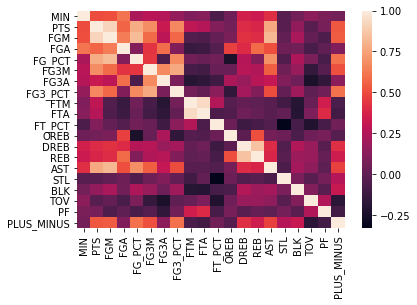

In [44]:
sns.heatmap(df.corr())

Based on the heatmap, we can have a rough estimate on the correaltions among all the features. We also plot the histogram of points data. The plot shows it is roughly normally distributed.

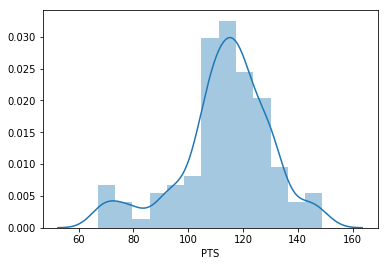

In [45]:
sns.distplot(df.PTS)

In [46]:
X = df[['MIN', 'FGM', 'FGA', 'FG_PCT','FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']]
y = df['PTS'] #original points data

In order to avoid cheating, that is using stats from the same match to predict final points, shift the order of y varible by 1 index backwards. As a result, we get a new dataframe that matches every game stats to it's next game's final points. After this, we can try fit a model on previous game stats to preidct the next game's points.

In [47]:
newy = list(y)
def shift(l, n):
    return l[n:] + l[:n]

newy = shift(newy,1) #new points data: 1 index backwards

Use ordinary least squares method to fit the model. OLS chooses the parameters of a linear function of a set of explanatory variables by the principle of least squares: minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being predicted) in the given dataset and those predicted by the linear function.

The model takes the form

${\displaystyle y_{i}=\beta _{0}1+\beta _{1}x_{i1}+\cdots +\beta _{p}x_{ip}+\varepsilon _{i}=\mathbf {x} _{i}^{\mathsf {T}}{\boldsymbol {\beta }}+\varepsilon _{i},\qquad i=1,\ldots ,n,} {\displaystyle y_{i}=\beta _{0}1+\beta _{1}x_{i1}+\cdots +\beta _{p}x_{ip}+\varepsilon _{i}=\mathbf {x} _{i}^{\mathsf {T}}{\boldsymbol {\beta }}+\varepsilon _{i},\qquad i=1,\ldots ,n,}$  
where T denotes the transpose, so that $x_{i}^Tβ$ is the inner product between vectors xi and β.

Often these n equations are stacked together and written in matrix notation as

${\displaystyle \mathbf {y} =X{\boldsymbol {\beta }}+{\boldsymbol {\varepsilon }},\,} {\displaystyle \mathbf {y} =X{\boldsymbol {\beta }}+{\boldsymbol {\varepsilon }},\,}$
where

${\displaystyle \mathbf {y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}},\quad } \mathbf {y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}},\quad 
{\displaystyle X={\begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix}}={\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix}},} {\displaystyle X={\begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix}}={\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix}},}
{\displaystyle {\boldsymbol {\beta }}={\begin{pmatrix}\beta _{0}\\\beta _{1}\\\beta _{2}\\\vdots \\\beta _{p}\end{pmatrix}},\quad {\boldsymbol {\varepsilon }}={\begin{pmatrix}\varepsilon _{1}\\\varepsilon _{2}\\\vdots \\\varepsilon _{n}\end{pmatrix}}.} {\displaystyle {\boldsymbol {\beta }}={\begin{pmatrix}\beta _{0}\\\beta _{1}\\\beta _{2}\\\vdots \\\beta _{p}\end{pmatrix}},\quad {\boldsymbol {\varepsilon }}={\begin{pmatrix}\varepsilon _{1}\\\varepsilon _{2}\\\vdots \\\varepsilon _{n}\end{pmatrix}}.}$

In [48]:
reg = LinearRegression().fit(X, newy)
reg.score(X, newy)

0.4152944863454989

The formula for adjusted R:
$$R_{adj}^2=1-\frac{n-1}{n-p}(1-R^2)$$
where $R^2=1-\frac{SS_{res}}{SS_{total}}$.

Print the dataframe that compares actual values and fitted values:

In [49]:
result = reg.predict(X)

In [50]:
difference = pd.DataFrame({'Actual': y, 'Predicted': result})
difference[:20]

,Actual,Predicted
0,70,100.899763
1,106,107.030343
2,92,103.732295
3,109,114.954052
4,109,108.629302
5,109,109.116360
6,119,121.256903
7,110,115.689420
8,114,120.772736
9,116,102.890737


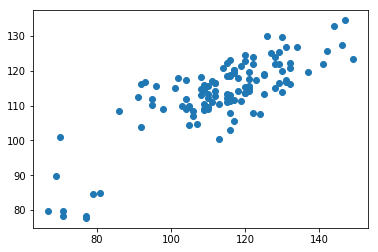

In [51]:
plt.scatter(y,result)

Our model only has 0.42 R square which is not very effective. Now, we apply linear regression again but on PCA applied matrix.

In [52]:
pca_re = finalpcadf.drop(columns=['WL'])
pca_re

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,-1.357814,2.011277,2.684226,-0.282948,-0.116063,0.305687
1,-0.022074,-1.015329,0.963206,0.513321,0.715412,1.957941
2,1.052361,-0.548400,-1.460084,-0.119417,1.248394,0.338701
3,-1.018031,4.094962,-2.010632,0.096870,-0.333105,1.145338
4,0.285480,0.532209,0.387468,3.255767,-0.529845,-1.623440
5,2.896570,0.828845,0.966934,-2.142450,-1.540571,-1.058566
6,-1.068726,-2.976762,0.559634,0.303697,-1.610686,1.163474
7,-1.488618,-0.363371,0.950845,-0.730997,2.582336,-1.040607
8,-5.123504,-1.473490,-1.826601,-0.874196,-0.672164,-1.042870
9,5.844355,-1.089941,-1.214997,-0.019648,0.256291,-0.145657


In [53]:
pca_y = finalpcadf.WL
pca_y

0    1
1    0
2    0
3    1
4    1
5    1
6    0
7    0
8    0
9    1
Name: WL, dtype: int64

In [54]:
reg = LinearRegression().fit(pca_re, pca_y)
reg.score(pca_re, pca_y)

0.9225232961774246

The R square value skyrockets to 0.92. This is a huge improvement compared wtih original regression model. We conclude that that there is a regression model that can predict next match's points based on previous match's data. PCA version of the regression model is much more effecitve than traditonal model. For future studies, we can use time series methods since the date of the match can also be included in analysis.